In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
import math
import pandas as pd
import xgboost
import lightgbm
import catboost

from matplotlib.colors import ListedColormap
from scipy.stats import pearsonr
from itertools import combinations
from sklearn.base import BaseEstimator
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.ensemble import (RandomForestClassifier,
                              ExtraTreesClassifier,
                              VotingClassifier)
from sklearn.tree import (DecisionTreeRegressor,
                          DecisionTreeClassifier)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score, accuracy_score

In [12]:
plt.rcParams["figure.figsize"] = 12, 9
sns.set_style("whitegrid")
warnings.filterwarnings("ignore")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

### Задание 1. Bias-variance trade-off

**2 балла**

Продемонстрируйте bias-variance trade-off для `DecisionTreeRegressor` при изменении глубины дерева. Постройте регрессионную модель функции от одной независимой переменной, представленной в ячейке ниже, используя функцию `plot_regression_predictions` (можете ее как-то поменять, если захочется). Попробуйте разные значения глубины деревьев, при каком значении, на ваш взгляд, модель оптимальна, при каком variance становится слишком большим?

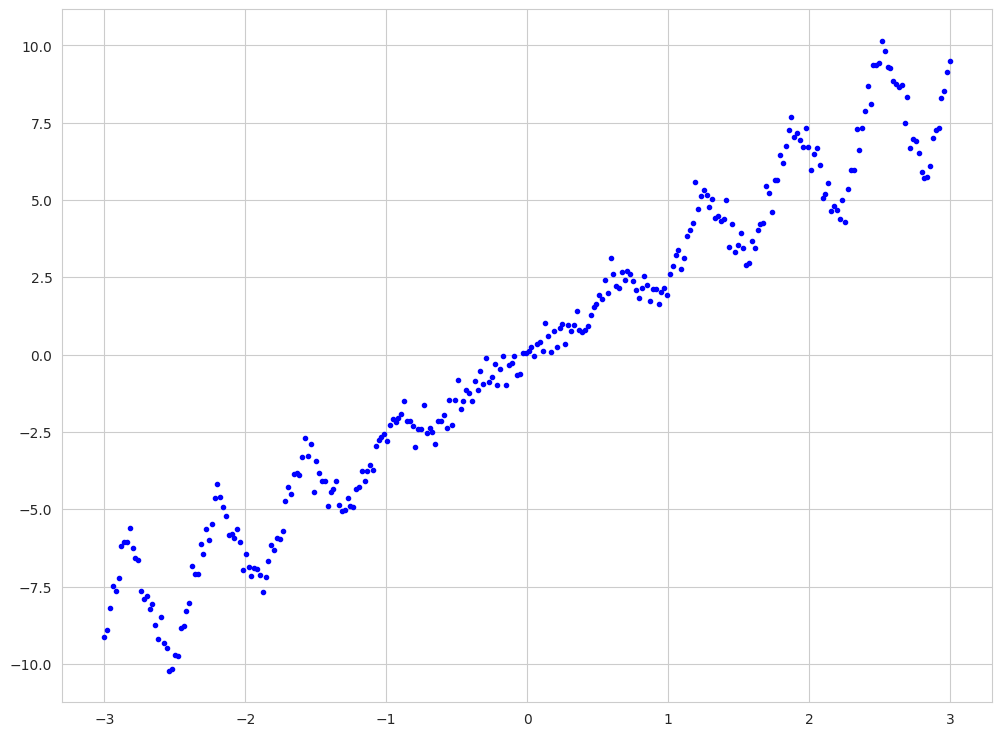

In [7]:
# Сгенерируем какую-нибудь необычную зависимость и научимся ее предсказывать
np.random.seed(42)
m = 300
X = np.linspace(-3, 3, m).reshape(-1, 1)
y = (3 + 2/np.pi * np.arcsin(np.cos(10 * X))) * X
y = y + np.random.randn(m, 1) / 3
plt.plot(X.reshape(-1), y.reshape(-1), "b.");

In [31]:
# Функция для отрисовки предсказаний деревьев решений в случае регрессии
def plot_regression_predictions(tree_reg, X, y, axes=[-3, 3, -10, 10], ylabel="$y$", max_depth=0):
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = tree_reg.predict(x1)
    plt.axis(axes)
    plt.xlabel("$x_1$", fontsize=18)
    if ylabel:
        plt.ylabel(ylabel, fontsize=18, rotation=0)
    
    cmap = plt.get_cmap('tab20b')
    colors = cmap(np.linspace(0,1,20))
    
    plt.plot(x1, y_pred, linewidth=2, alpha=0.5, c=colors[i], label=r"$\hat{y}$"+f'\tmax depth={i}')
    plt.legend()

Изобразите, как меняются предсказания дерева при увеличении максимальной глубины (можно взять что-то в диапазоне от 1 до 15):

In [2]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

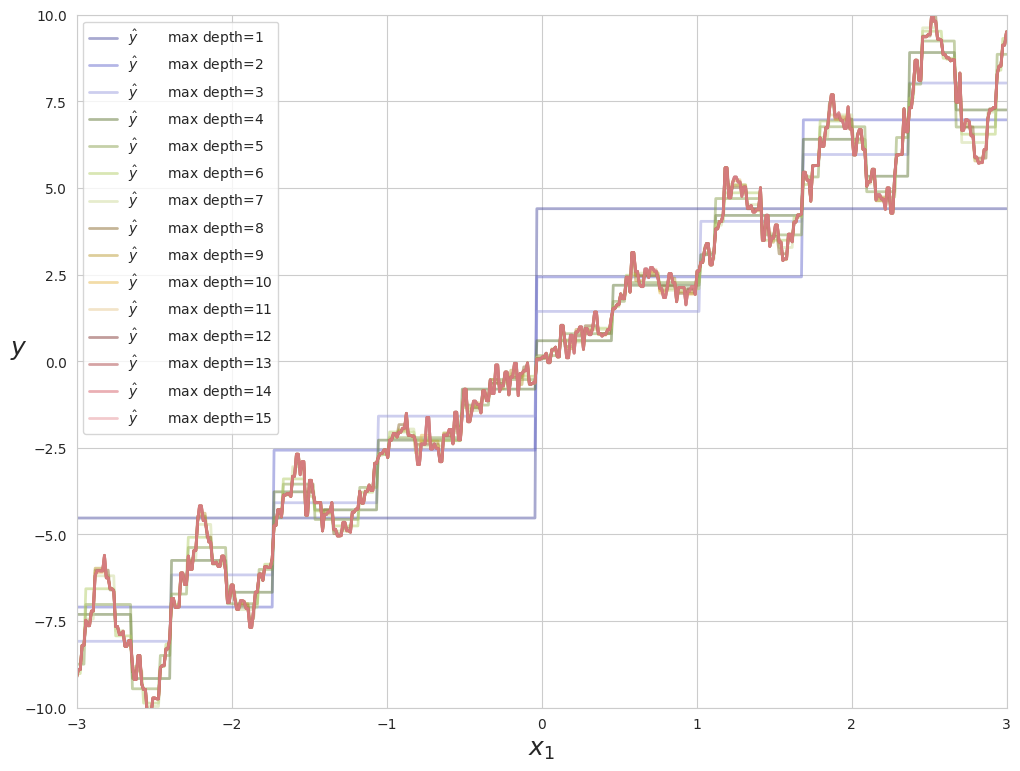

In [32]:
for i in range(1, 16):
    tree_reg = DecisionTreeRegressor(max_depth=i)
    tree_reg.fit(X,y)
    plot_regression_predictions(tree_reg, X, y, max_depth=i)

### Задание 2. Random forest

Теперь давайте немного подготовимся к тому, чтобы реализовать свой собственный случайный лес, а потом реализуем его.

#### Задание 2. 1. Простое ансамблирование

**1 балла**

Представим, что у нас есть 101 классификатор. Каждый может с вероятностью `p` (равной для всех моделей) правильно предсказать класс объекта. Будем делать предсказания по большинству голосов (majority vote). Постройте зависимость вероятности правильно классифицировать объект от значения `p`. Вам может быть полезная следующая формула:

$$ \large \mu = \sum_ {i = 51} ^ {101} C_{101} ^ ip ^ i (1-p) ^ {101-i} $$

In [3]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

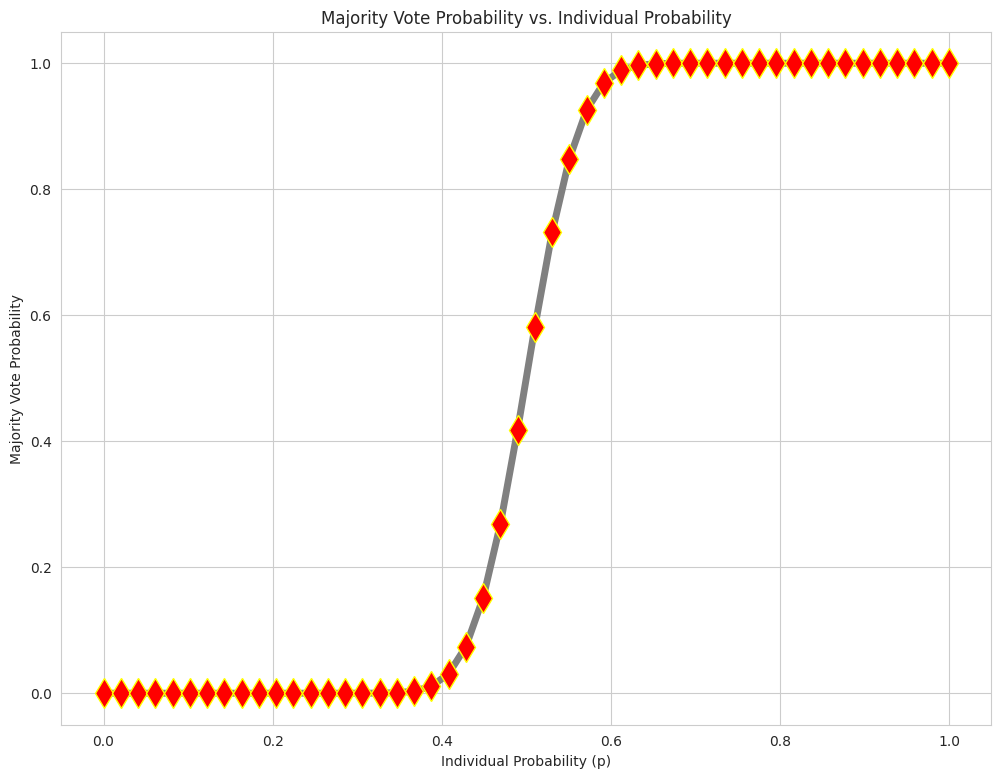

In [65]:
def calculate_majority_vote_probability(p):
    mu = 0
    for i in range(51, 101+1):
        mu += (math.factorial(101) / (math.factorial(i) * math.factorial(101 - i))) * (p**i) * ((1.0 - p)**(101 - i))
    return mu

p_values = np.linspace(0, 1, 50)
y = [calculate_majority_vote_probability(p) for p in p_values]

plt.plot(p_values, y, linewidth=5, color="gray", marker="d", markersize=15, mec="yellow", mfc="red")
plt.xlabel('Individual Probability (p)')
plt.ylabel('Majority Vote Probability')
plt.title('Majority Vote Probability vs. Individual Probability')
plt.grid(True)
plt.show()

А теперь давайте посмотрим на другую ситуацию. У нас есть фиксированная вероятность того, что модель правильно классифицирует объект `p = 0.65`. Постройте зависимость вероятности правильно классифицировать объект от числа моделей в ансамбле.

In [4]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

In [ ]:
plt.plot(p_values, y, linewidth=5, color="gray", marker="d", markersize=15, mec="yellow", mfc="red")

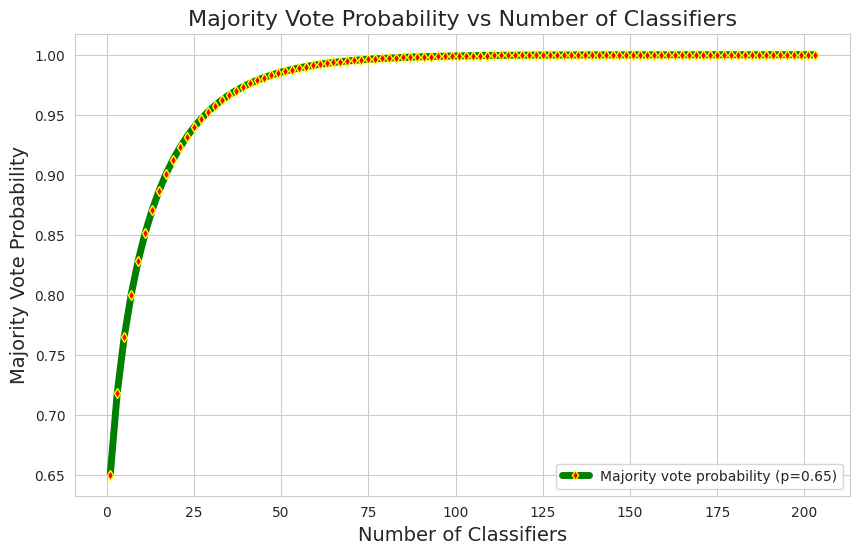

In [79]:
def calculate_majority_vote_prob(n_classifiers, p=0.65):
    y = []
    for n in n_classifiers:
        mu = 0
        for i in range(n // 2 + n % 2, n + 1):
            mu += (math.factorial(n) / (math.factorial(i) * math.factorial(n - i))) * (p**i) * ((1.0 - p)**(n - i))
        y.append(mu)
    return y

n_classifiers = list(range(1, 205, 2))
y = calculate_majority_vote_prob(n_classifiers)

plt.figure(figsize=(10, 6))
plt.plot(n_classifiers, y, label=f'Majority vote probability (p={p})', linewidth=5, color="green", marker="d", markersize=5, mec="yellow", mfc="red")
plt.xlabel('Number of Classifiers', fontsize=14)
plt.ylabel('Majority Vote Probability', fontsize=14)
plt.title('Majority Vote Probability vs Number of Classifiers', fontsize=16)
plt.legend()
plt.grid(True)
plt.show()

Опишите ваши наблюдения:

* Повышение вероятности точной оценки напрямую связано с увеличением вероятности верного классифицирования моделей в ансамблях
* А также с ростом количества моделей в этих ансамблях

#### Задание 2. 2. Реализация простого RF

**4 балла**

Реализуйте свой собственный класс `RandomForestClassifierCustom`, используя в качестве базовой модели `DecisionTreeClassifier` из `sklearn`.

Небольшое описание:
- Используйте приведенный ниже код
- В методе `fit` в цикле (`i` от 0 до `n_estimators-1`):
    * Зафиксируйте генератор случайных чисел следующим образом np.random.seed(`random_state + i`). Идея в том, что на каждой итерации у нас будет новое значение для генератора случайных чисел, что добавит побольше "случайности", но в то же время мы сможем иметь воспроизводимые результаты
    * После чего выберите `max_features` признаков **без возвращения/without replacement**, сохраните список выбранных признаков (их индексов) в `self.feat_ids_by_tree`
    * Также создайте псевдовыборку при помощи бутстрэпа (выбор **с возвращением/with replacement**) из тренировочных данных. Может помочь функция `np.random.choice` и ее аргумент `replace`
    * Обучите дерево решений с параметрами, заданными в конструкторе класса `max_depth`, `max_features` и `random_state` на полученной псевдовыборке.
- Метод `fit` должен возвращать текущий экземпляр класса `RandomForestClassifierCustom`, то есть `self` (все по-взрослому, как в `sklearn`)
- В методе `predict_proba` мы должны пройти циклом по всем деревьям. Для каждого предсказания, нам нужно будет брать только те признаки, на которых училось изначальное дерево, поэтому мы и сохраняли эту информацию в артрибуте `self.feat_ids_by_tree`. Этот метод должен возвращать предсказанные вероятности (можно делать двумя способами: для каждого дерева предсказывать значение при помощи метода `predict_proba` и потом усреднять эти вероятности, или к примеру пользоваться методом `predict` и также считать среднее.

In [81]:
class RandomForestClassifierCustom(BaseEstimator):
    def __init__(
        self, n_estimators=10, max_depth=None, max_features=None, random_state=SEED
    ):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.max_features = max_features
        self.random_state = random_state

        self.trees = []
        self.feat_ids_by_tree = []

    def fit(self, X, y):
        self.classes_ = sorted(np.unique(y))
    
        # ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##
        for i in range(self.n_estimators):  
            np.random.seed(self.random_state + i)
            
            # Randomly select feature indices for the current tree
            feat_ids = np.random.choice(range(X.shape[1]), size=self.max_features, replace=False)
            self.feat_ids_by_tree.append(feat_ids)

            # Create pseudo dataset using random indices with replacement
            pseudo_ids = np.random.choice(range(X.shape[0]), size=X.shape[0], replace=True)
            pseudo_X = X[pseudo_ids, :][:,self.feat_ids_by_tree[i]]
            pseudo_y = y[pseudo_ids]

            # Create and fit a Decision Tree Classifier for the current tree
            dt_clf = DecisionTreeClassifier(
                max_depth=self.max_depth,
                max_features=self.max_features,
                random_state=self.random_state + i
                )
            dt_clf.fit(pseudo_X, pseudo_y)
    
            # Append the trained Decision Tree to the ensemble
            self.trees.append(dt_clf)

        return self


    def predict_proba(self, X):
        # ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##
        proba_sum = 0
        
        for i, tree in enumerate(self.trees):
            # Predict probabilities using the current tree and selected features
            tree_proba = tree.predict_proba(X[:, self.feat_ids_by_tree[i]])
            
            # Accumulate probabilities from all trees
            proba_sum += tree_proba
        
        # Average the accumulated probabilities over all trees
        averaged_proba = proba_sum / self.n_estimators
        
        return averaged_proba

    
    def predict(self, X):
        probas = self.predict_proba(X)
        predictions = np.argmax(probas, axis=1)
        
        return predictions

Протестируем нашу реализацию на искусственных данных. Визуализируйте разделяющую границу, которую рисует ваша модель при помощи функции `plot_decision_boundary` (см. примеры в лекции).

In [83]:
def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(["#ffdab9","#9898ff", "#4B0082"])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(["#ffdab9", "#4c4c7f", "#4B0082"])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

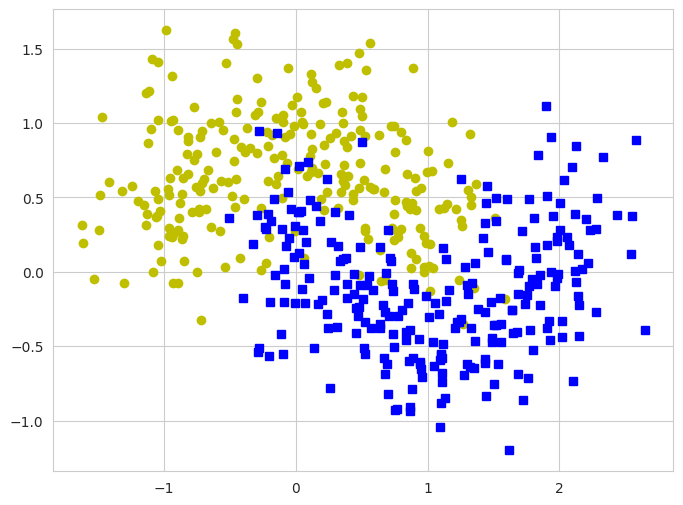

In [84]:
X, y = datasets.make_moons(n_samples=500, noise=0.30, random_state=SEED)

plt.figure(figsize=(8, 6))
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo")
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs")
plt.show()

In [5]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

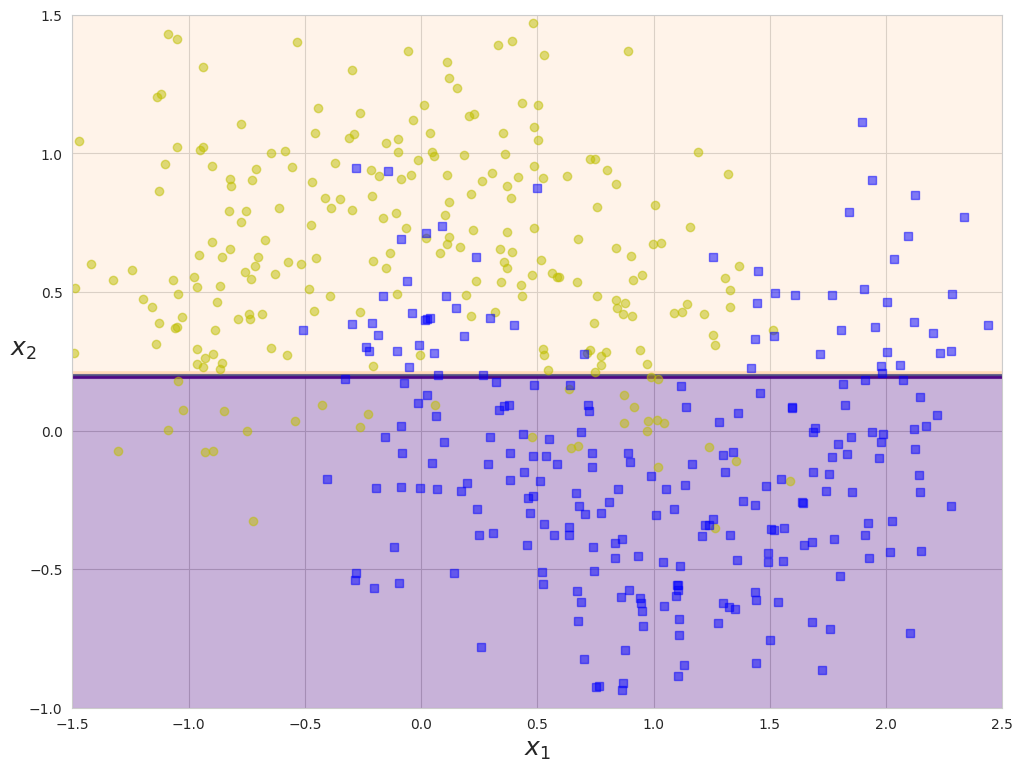

In [85]:
rf_cls = RandomForestClassifierCustom(max_depth=1, n_estimators=1000, max_features=2)
rf_cls.fit(X, y)
plot_decision_boundary(rf_cls, X, y)

Подберите наилучшие гиперпараметры, при которых разделяющая граница будет, на ваш взгляд, оптимальной с точки зрения bias-variance. Можно также подключить какие-то метрики для выбора лучшей модели.

In [ ]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

In [88]:
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold

In [89]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)

# Define the parameter grid
parameters = {
    "n_estimators": list(range(10, 100, 5)) + list(range(100, 1000, 100)),
    "max_depth": list(range(1, 26)),
    "max_features": [1, 2],
    "random_state": [SEED]
}

# Create a RandomForestClassifier instance
rf_classifier = RandomForestClassifier()

# Initialize GridSearchCV with the custom RandomForestClassifier
param_search = GridSearchCV(estimator=rf_classifier,
                            param_grid=parameters,
                            scoring="accuracy",
                            n_jobs=-1,
                            cv=5)  # Add cross-validation for better evaluation

# Perform grid search on the training data
param_search.fit(X_train, y_train)

# Print the best parameters and corresponding accuracy
print("Best Parameters:", param_search.best_params_)
print("Best Accuracy:", param_search.best_score_)

Best Parameters: {'max_depth': 5, 'max_features': 2, 'n_estimators': 10, 'random_state': 111}
Best Accuracy: 0.9306666666666666


In [91]:
from sklearn.metrics import (precision_score, recall_score, f1_score, accuracy_score,
                             confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay,
                             roc_curve, auc, roc_auc_score, classification_report)

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.92      0.92        65
           1       0.92      0.92      0.92        60

    accuracy                           0.92       125
   macro avg       0.92      0.92      0.92       125
weighted avg       0.92      0.92      0.92       125



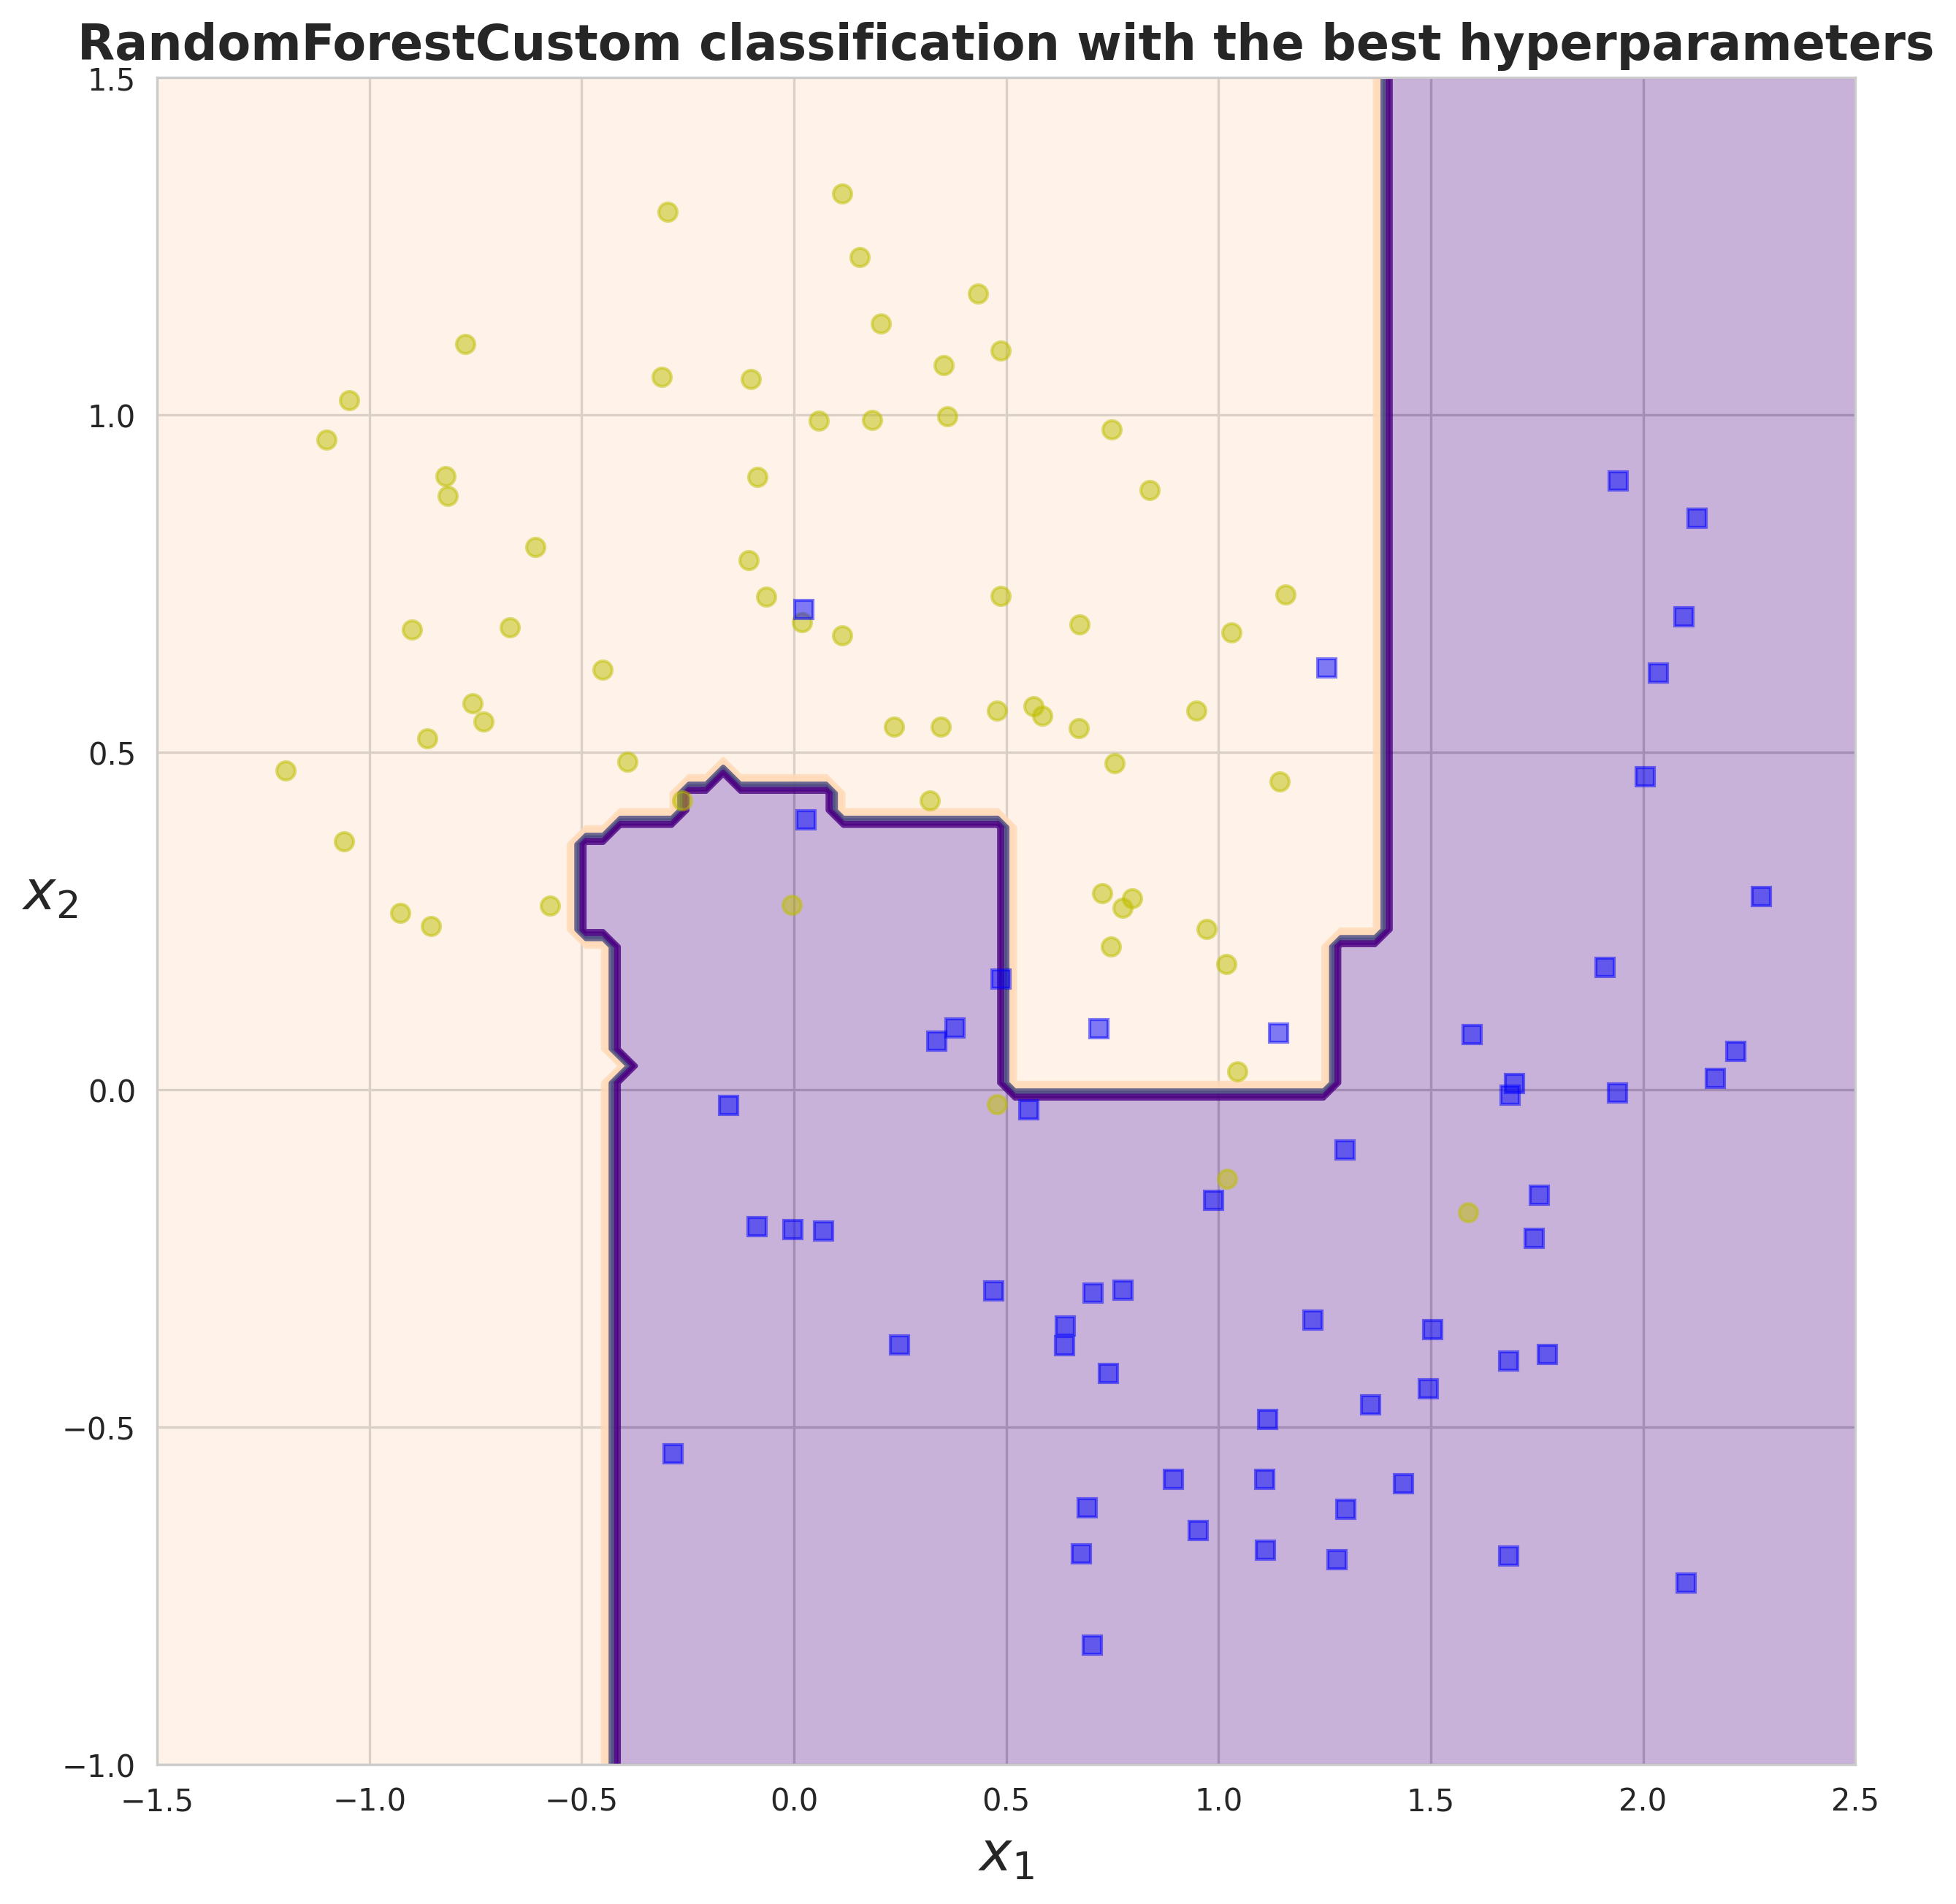

In [93]:
# Create and fit the custom RandomForestClassifier
custom_rf = RandomForestClassifierCustom(n_estimators=10, max_depth=5, max_features=2, random_state=SEED)
custom_rf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = custom_rf.predict(X_test)

# Print classification report with multiple metrics
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Plot the decision boundary
fig, ax = plt.subplots(figsize=(10, 10), dpi=300)
plot_decision_boundary(custom_rf, X_test, y_test)
plt.title("RandomForestCustom classification with the best hyperparameters", fontsize=16, fontweight="bold")
plt.show()

#### Задание 2. 3. Корреляция базовых моделей

**3 балла**

Как мы выянили на лекции, для того, чтобы bagging работал хорошо, предсказания наших моделей не должны сильно коррелировать. Для этого в случайном лесе применяются различные подходы, в том числе и RSM. Давайте посмотрим, как влияет параметр `max_features` на корреляцию базовых моделей в случайном лесу из `sklearn`. В качестве примера будем использовать датасет `breast_cancer`. Для расчета корреляций используйте приведенную ниже функцию `base_model_pair_correlation`. Для каждой модели у вас будет получаться набор значений (попарные корреляции всех деревьев), дальше можно изобразить их в виде боксплотов, как мы на лекции рисовали распределение метрик.

In [94]:
# Функция для расчета попарных корреляций базовых моделей в случайном лесу
def base_model_pair_correlation(ensemble, X):
    corrs = []
    for (i, est1), (j, est2) in combinations(enumerate(ensemble.estimators_), 2):
        Xi_test = X
        Xj_test = X

        ypred_t1 = est1.predict_proba(Xi_test)[:, 1]
        ypred_t2 = est2.predict_proba(Xj_test)[:, 1]

        corrs.append(pearsonr(ypred_t1, ypred_t2)[0])
    return np.array(corrs)

In [95]:
# Загрузим данные
breast_cancer = datasets.load_breast_cancer()
X = breast_cancer.data
y = breast_cancer.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [6]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

In [96]:
max_features = list(range(1, X.shape[1] + 1, 2))
max_features_dict = {n: base_model_pair_correlation(RandomForestClassifier(max_depth=15, max_features=n, n_estimators=300).fit(X_train, y_train), X_test) for n in max_features}

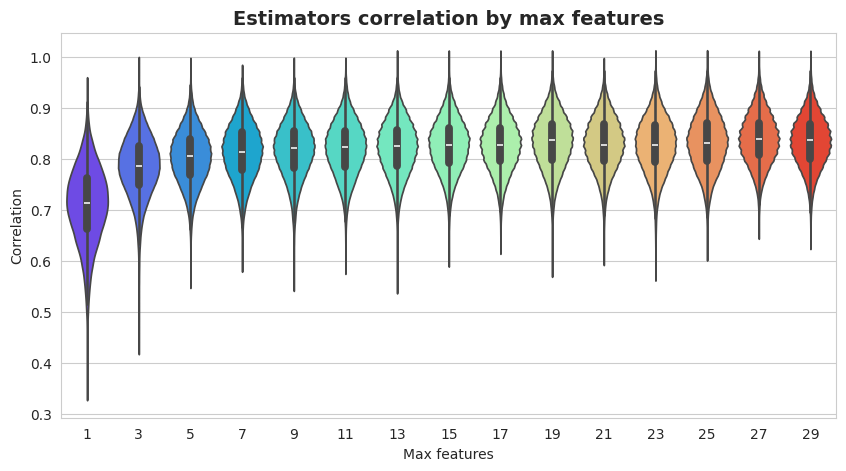

In [109]:
max_features_df = pd.DataFrame(max_features_dict)

plt.figure(figsize=(10, 5))
sns.violinplot(data=max_features_df, palette="rainbow")
plt.title("Estimators correlation by max features", fontsize=14, fontweight="bold")
plt.xlabel("Max features")
plt.ylabel("Correlation")
plt.show()

Теперь давайте посмотрим, как на это влияет параметр `max_depth`:

In [7]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

In [98]:
max_depth = [1, 2, 5, 10, 15, 25, 50, 100, 200]
max_depth_dict = {i: base_model_pair_correlation(RandomForestClassifier(max_depth=i, n_estimators=300).fit(X_train, y_train), X_test) for i in max_depth}

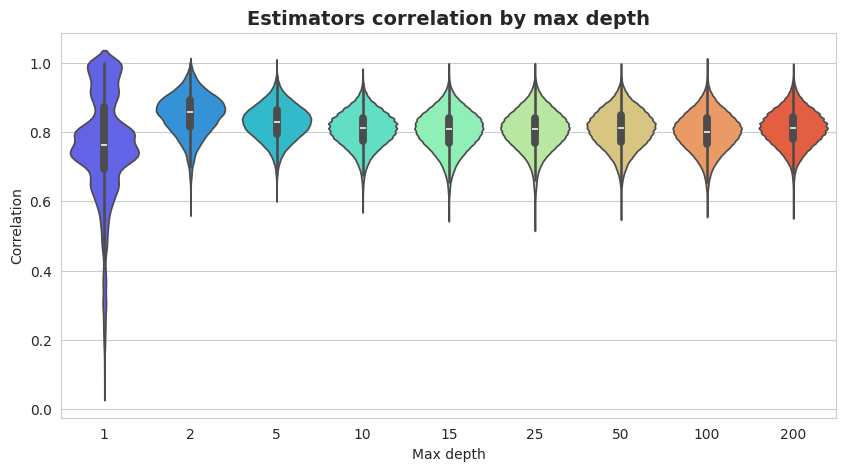

In [107]:
max_depth_df = pd.DataFrame(max_depth_dict)

plt.figure(figsize=(10, 5))
sns.violinplot(data=max_depth_df, palette="rainbow")
plt.title("Estimators correlation by max depth", fontsize=14, fontweight="bold")
plt.xlabel("Max depth")
plt.ylabel("Correlation")
plt.show()

Опишите ваши наблюдения:

* При увеличении параметра `max_features` наблюдается усиление корреляции оценок, однако данная корреляция достигает плато при достаточно больших значениях этого параметра
* Аналогично, изменяя параметр `max_depth`, мы также наблюдаем наличие плато, при этом при небольших значениях данного параметра корреляция между оценками может быть более высокой.

### Задание 3. Строим большой ансамбль

**4 балла + 3 дополнительных за скор выше 0.87**

В данной задаче вам нужно диагностировать сердечное заболевание у людей по медицинским показателям.

In [3]:
#!gdown  --id 1VFbDK-Ad-hpf0_GGCBzn4thdn9mkQ-Y- -O heart.csv -q
heart_dataset = pd.read_csv("../data/heart.csv")

In [4]:
X = heart_dataset.drop("target", axis=1)
y = heart_dataset["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)
X_train.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
178,43,1,0,120,177,0,0,120,1,2.5,1,0,3
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3
201,60,1,0,125,258,0,0,141,1,2.8,1,1,3
246,56,0,0,134,409,0,0,150,1,1.9,1,2,3
153,66,0,2,146,278,0,0,152,0,0.0,1,1,2


Обучите разнообразные классификаторы, приведенные ниже, а также ансамбль `VotingClassifier` из `sklearn.ensemble`, объединяющий эти классификаторы с помощью жесткого или мякого голосования (параметр `voting =` `'hard'` или `'soft'` соответственно). Оцените качество моделей с помощью кросс-валидации на тренировочном наборе, используя функцию `cross_val_score` и метрику `f1`. Часть моделей отсюда мы не проходили, о них можно почитать дополнительно, но в принципе для задания не очень важно знать принципы их работы (но, если есть время, то почитайте, там интересно).

In [5]:
dt = DecisionTreeClassifier(random_state=SEED, max_depth=10, min_samples_leaf=10)
rf = RandomForestClassifier(n_estimators=50, random_state=SEED)
etc = ExtraTreesClassifier(random_state=SEED)
knn = KNeighborsClassifier(n_neighbors=5, weights="distance")
svc_lin = SVC(kernel='linear', probability=True, random_state=SEED)
svc_rbf = SVC(kernel='rbf', probability=True, random_state=SEED)
cat = catboost.CatBoostClassifier(verbose=0, random_seed=SEED)
lgbm = lightgbm.LGBMClassifier(random_state=SEED)
lgbm_rf = lightgbm.LGBMClassifier(boosting_type="rf", bagging_freq=1, bagging_fraction=0.7, random_state=SEED)
xgb = xgboost.XGBClassifier(random_state=SEED)
xgb_rf = xgboost.XGBRFClassifier(random_state=SEED)
lr = LogisticRegression(solver='liblinear', max_iter=10000)
nb = GaussianNB()

base_models = [("DT", dt), ("RF", rf), 
               ("ETC", etc), ("KNN", knn), 
               ("SVC_LIN", svc_lin), ("SVC_RBF", svc_rbf), 
               ("CAT", cat), ("LGBM", lgbm), 
               ("LGBM_RF", lgbm_rf), ("XGB", xgb), 
               ("XGB_RF", xgb_rf), ("LR", lr), ("NB", nb)]

Здесь могут возникать различные предупреждения при обучении бустингов, не волнуйтесь, все нормально, просто они обычно очень разговорчивые)

**Прим.: А как их убрать...? Гуглил, вроде как-то лечится, но всё равно фигня какая-то получалась... Буду благодарен за подсказку**

In [6]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

voting_hard = VotingClassifier(estimators = base_models, voting="hard")
voting_soft = VotingClassifier(estimators = base_models, voting="soft")

## END YOUR CODE HERE ##

for model in [dt, rf, cat, etc, knn, svc_lin, svc_rbf, xgb, lgbm, xgb_rf, lgbm_rf, lr, nb, voting_hard, voting_soft]: 
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring="f1")
    print(f"{model.__class__.__name__}: {scores.mean()}")

DecisionTreeClassifier: 0.797997226792219
RandomForestClassifier: 0.8328751280279528
CatBoostClassifier: 0.8342715174922052
ExtraTreesClassifier: 0.8281746031746032
KNeighborsClassifier: 0.6493313763861709
SVC: 0.8403098469098905
SVC: 0.6973119072190279
XGBClassifier: 0.8134522115571786
[LightGBM] [Info] Number of positive: 79, number of negative: 72
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000970 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 190
[LightGBM] [Info] Number of data points in the train set: 151, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.523179 -> initscore=0.092782
[LightGBM] [Info] Start training from score 0.092782
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [War

Вы можете заметить, что ансамбль показывает хорошее, но не лучшее качество предсказания, попробуем его улучшить. Как вы знаете, ансамбли работают лучше, когда модели, входящие в них не скоррелированы друг с другом. Определите корреляцию предсказаний базовых моделей в ансамбле на тестовом наборе данных, и удалите из ансамбля те модели, чьи предсказания будут сильнее коррелировать с остальными. Воспользуйтесь функцией `base_model_pair_correlation_for_voting_clf`. **Спойлер**: далеко не факт, что если вы удалите две модели с корреляцией 0.95, то все станет сильно лучше, здесь все будет немного сложнее. Чтобы добиться максимального качества может понадобиться долгий перебор различных комбинаций моделей. Наилучший скор, который мне удалось достичь, это 0.915, но он получен весьма странной комбинацией алгоритмов, а еще и простым перебором всех вариантов)

In [7]:
def base_model_pair_correlation_for_voting_clf(ensemble, X):
    corrs = []
    base_model_names = [f"{est.__class__.__name__}" for est in ensemble.estimators_]
    for (i, est1), (j, est2) in combinations(enumerate(ensemble.estimators_), 2):
        Xi_test = X
        Xj_test = X

        if not isinstance(est1, SVC):
            ypred_t1 = est1.predict_proba(Xi_test)[:, 1]
        else:
            ypred_t1 = est1.decision_function(Xi_test)


        if not isinstance(est2, SVC):
            ypred_t2 = est2.predict_proba(Xi_test)[:, 1]
        else:
            ypred_t2 = est2.decision_function(Xi_test)
        corrs.append((est1, est2, pearsonr(ypred_t1, ypred_t2)[0]))


    return corrs

In [120]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

In [ ]:
voting_hard.fit(X_train, y_train);
voting_soft.fit(X_train, y_train);

In [9]:
corrs = base_model_pair_correlation_for_voting_clf(voting_hard, X_train)

for i in corrs:
    if i[2] > 0.95:
        print(i[0].__class__.__name__, i[1].__class__.__name__, 'corr score:', i[2])

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging

**Дисклеймер на случай, если я сделал что-то тупое**

Да, спойлер к заданию указывал, что тупо удалить все скоррелированные модели не даёт 10000% гарантии в лучшем результате. Но по итогу то `f1 score` что у `hard`, что у `soft` получились ого-го какие! Образцовые! Или я упускаю что-то очень важное?

In [44]:
base_models_new = [
                ("LR", lr), 
                ("NB", nb)
                ]
voting_hard = VotingClassifier(estimators=base_models_new, voting='hard')
voting_soft = VotingClassifier(estimators=base_models_new, voting='soft')

voting_hard.fit(X_train, y_train)
voting_soft.fit(X_train, y_train)

scores_hard = cross_val_score(voting_hard, X_train, y_train, cv=3, scoring="f1")
scores_soft = cross_val_score(voting_soft, X_train, y_train, cv=3, scoring="f1")

y_pred_hard = voting_hard.predict(X_test)
y_pred_soft = voting_soft.predict(X_test)

f1_hard = f1_score(y_test, y_pred_hard)
f1_soft = f1_score(y_test, y_pred_soft)

print(f'Hard:\nf1 score = {f1_hard},\ncross val scores = {scores_hard},\ncross val scores mean = {scores_hard.mean()}')
print(f'Soft:\nf1 score = {f1_soft},\ncross val scores = {scores_soft},\ncross val scores mean = {scores_soft.mean()}')

Hard:
f1 score = 0.9052631578947369,
cross val scores = [0.90666667 0.77333333 0.81927711],
cross val scores mean = 0.8330923694779117
Soft:
f1 score = 0.9072164948453608,
cross val scores = [0.8974359  0.79487179 0.8045977 ],
cross val scores mean = 0.8323017978190391


### Задание 4. Определение оттока клиентов из телекома

**6 баллов + 7 дополнительных за высокое качество модели и различные эксперименты**

Будем предсказывать, уйдет ли от нас клиент (переменная `Churn?`). Данные можно скачать [здесь](https://www.kaggle.com/venky12347/churn-telecom). Это будет уже совсем взрослое задание, так как правильного ответа на него нет. Вам нужно будет разобраться с данными, правильно подготовить их для моделей, а также выбрать лучшую модель. 

Задача минимум:

Выберите 2 модели &mdash; один случайный лес и один бустинг из приведенных ниже:

1. `xgboost.XGBClassifier`
2. `xgboost.XGBRFClassifier` &mdash; случайный лес от xgboost
3. `lightgbm.LGBMClassifier`
4. `lightgbm.LGBMClassifier(boosting_type="rf")` &mdash; случайный лес от lightgbm
5. `catboost.CatBoostClassifier`

И попробуйте разобраться с тем, как для этих моделей правильно настраивать гиперпараметры. Советую гуглить примерно следующее `how to choose best hyperparameters for lightgbm`. Там вы найдете кучу сложного и непонятного кода, но если с ним разобраться и научиться обучать нестандартные бустинги, то в плане табличных данных равных вам не будет)

In [2]:
data = pd.read_csv("../data/churn.csv")
data.head()

,State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,...,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False.
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False.
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False.
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False.
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False.


#### **EDA**

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   State           3333 non-null   object 
 1   Account Length  3333 non-null   int64  
 2   Area Code       3333 non-null   int64  
 3   Phone           3333 non-null   object 
 4   Int'l Plan      3333 non-null   object 
 5   VMail Plan      3333 non-null   object 
 6   VMail Message   3333 non-null   int64  
 7   Day Mins        3333 non-null   float64
 8   Day Calls       3333 non-null   int64  
 9   Day Charge      3333 non-null   float64
 10  Eve Mins        3333 non-null   float64
 11  Eve Calls       3333 non-null   int64  
 12  Eve Charge      3333 non-null   float64
 13  Night Mins      3333 non-null   float64
 14  Night Calls     3333 non-null   int64  
 15  Night Charge    3333 non-null   float64
 16  Intl Mins       3333 non-null   float64
 17  Intl Calls      3333 non-null   i

In [4]:
print('\033[1m' + "\nNumber of observations (rows):\n" + '\033[0m'f"{data.shape[0]}")
print('\033[1m' + "Number of parameters (columns):\n" + '\033[0m'f"{data.shape[1]}")


Number of observations (rows):
3333
Number of parameters (columns):
21


In [5]:
data.describe()

,Account Length,Area Code,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls
count,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000
mean,101.064806,437.182418,8.099010,179.775098,100.435644,30.562307,200.980348,100.114311,17.083540,200.872037,100.107711,9.039325,10.237294,4.479448,2.764581,1.562856
std,39.822106,42.371290,13.688365,54.467389,20.069084,9.259435,50.713844,19.922625,4.310668,50.573847,19.568609,2.275873,2.791840,2.461214,0.753773,1.315491
min,1.000000,408.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.200000,33.000000,1.040000,0.000000,0.000000,0.000000,0.000000
25%,74.000000,408.000000,0.000000,143.700000,87.000000,24.430000,166.600000,87.000000,14.160000,167.000000,87.000000,7.520000,8.500000,3.000000,2.300000,1.000000
50%,101.000000,415.000000,0.000000,179.400000,101.000000,30.500000,201.400000,100.000000,17.120000,201.200000,100.000000,9.050000,10.300000,4.000000,2.780000,1.000000
75%,127.000000,510.000000,20.000000,216.400000,114.000000,36.790000,235.300000,114.000000,20.000000,235.300000,113.000000,10.590000,12.100000,6.000000,3.270000,2.000000
max,243.000000,510.000000,51.000000,350.800000,165.000000,59.640000,363.700000,170.000000,30.910000,395.000000,175.000000,17.770000,20.000000,20.000000,5.400000,9.000000


In [6]:
data.isnull().sum()

State             0
Account Length    0
Area Code         0
Phone             0
Int'l Plan        0
VMail Plan        0
VMail Message     0
Day Mins          0
Day Calls         0
Day Charge        0
Eve Mins          0
Eve Calls         0
Eve Charge        0
Night Mins        0
Night Calls       0
Night Charge      0
Intl Mins         0
Intl Calls        0
Intl Charge       0
CustServ Calls    0
Churn?            0
dtype: int64

Всё в целом ок. Выбросов нет, пропущенных значений нет. Единственное, что смущает - названия переменных. `Int'l Plan` и т.д. Надо избавиться от специальных символов.

In [7]:
data.columns = data.columns.str.replace(" ", "_")
data.columns = data.columns.str.replace("?", "")
data.columns = data.columns.str.replace("'", "")
data.head(1)

,State,Account_Length,Area_Code,Phone,Intl_Plan,VMail_Plan,VMail_Message,Day_Mins,Day_Calls,Day_Charge,...,Eve_Calls,Eve_Charge,Night_Mins,Night_Calls,Night_Charge,Intl_Mins,Intl_Calls,Intl_Charge,CustServ_Calls,Churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.7,1,False.


In [8]:
print(data["Churn"].value_counts())

Churn
False.    2850
True.      483
Name: count, dtype: int64


Хороший такой дисбаланс замечен.
Также я прямо здесь поменяю значения в колоках `Churn`, `Intl_Plan` и `VMail_Plan`.

In [9]:
data['Churn'].replace({'False.': 0, 'True.': 1}, inplace=True)
data['Intl_Plan'] = data['Intl_Plan'].apply(lambda x: 1 if x=="yes" else 0)
data['VMail_Plan'] = data['VMail_Plan'].apply(lambda x: 1 if x=="yes" else 0)

/tmp/ipykernel_19435/1001631181.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data["Churn"].replace({'False.': 0, 'True.': 1}, inplace=True)
/tmp/ipykernel_19435/1001631181.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data["Churn"].replace({'False.': 0, 'True.': 1}, inplace=True)


In [24]:
print(len(data["State"].unique()))

51


И ещё я уберу `State`,`Area_Code` и `Phone`.
Почему убрал `State`? Потому что там много штатов, их придётся обрабатывать `OHE`, и там будет аж 51 (ну 50) различных значений!!! `Accuracy score` таким образом улетит в минуса...

In [26]:
data_clean = data.drop(['State','Area_Code','Phone'],axis=1)

In [27]:
X=data_clean.drop(columns=['Churn'])
y=data_clean[['Churn']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state=SEED)

**Я решил пойти сугубо по программе минимум...**

**lightgbm.LGBMClassifier**

In [40]:
LGBMC = lightgbm.LGBMClassifier()
LGBMC.fit(X_train, y_train)
y_pred = LGBMC.predict(X_test)

[LightGBM] [Info] Number of positive: 329, number of negative: 1904
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000310 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2359
[LightGBM] [Info] Number of data points in the train set: 2233, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.147335 -> initscore=-1.755654
[LightGBM] [Info] Start training from score -1.755654


In [41]:
print(f'Accuray = {accuracy_score(y_test, y_pred)}')
print(f'F1 score = {f1_score(y_test, y_pred)}')

Accuray = 0.9509090909090909
F1 score = 0.8043478260869565


**lightgbm.LGBMClassifier(boosting_type="rf") &mdash; случайный лес от lightgbm**

In [37]:
LGBMCRF = lightgbm.LGBMClassifier(boosting_type="rf", bagging_freq=1, bagging_fraction=0.001)
LGBMCRF.fit(X_train, y_train)
y_pred_rf = LGBMCRF.predict(X_test)

[LightGBM] [Warning] bagging_fraction is set=0.001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.001
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.001
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Number of positive: 329, number of negative: 1904
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000628 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2359
[LightGBM] [Info] Number of data points in the train set: 2233, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.147335 -> initscore=-1.755654
[LightGBM] [Info] Start training from score -1.755654
[LightGBM] [Warning] No further splits with positive

In [39]:
print(f'Accuray = {accuracy_score(y_test, y_pred)}')
print(f'F1 score = {f1_score(y_test, y_pred)}')

Accuray = 0.9327272727272727
F1 score = 0.7338129496402878


**XGBClassifier**

In [42]:
XGBC = xgboost.XGBClassifier()
XGBC.fit(X_train, y_train)
y_pred = XGBC.predict(X_test)

In [43]:
print(f'Accuray = {accuracy_score(y_test, y_pred)}')
print(f'F1 score = {f1_score(y_test, y_pred)}')

Accuray = 0.95
F1 score = 0.7940074906367042


**xgboost.XGBRFClassifier &mdash; случайный лес от xgboost**

In [44]:
XGBRFC = xgboost.XGBRFClassifier()
XGBRFC.fit(X_train, y_train)
y_pred = XGBRFC.predict(X_test)

In [45]:
print(f'Accuray = {accuracy_score(y_test, y_pred)}')
print(f'F1 score = {f1_score(y_test, y_pred)}')

Accuray = 0.9327272727272727
F1 score = 0.7338129496402878


### Задание 5. Рисуем

**дополнительно 0.5 балла**

Наверняка, в процессе выполнения этого задания вас переполняли какие-то эмоции. Нарисуйте что-то, что бы могло бы передать их (я сам не умею, так что, если это будет просто квадрат, тоже подойдет). Прикрепите сюда свой рисунок:

In [ ]:
## PASTE YOUR MASTERPIECE HERE (/¯◡ ‿ ◡)/¯☆*##

### Therapy time

Напишите здесь ваши впечатления о задании (можно и не о задании): было ли интересно, было ли слишком легко или наоборот сложно и тд. Также сюда можно написать свои идеи по улучшению заданий, а также предложить данные, на основе которых вы бы хотели построить следующие дз.

**Ваши мысли:**